# Hello, PyTorch! -- MNIST Handwritten Digits

- https://en.wikipedia.org/wiki/MNIST_database

# Load Datasets

In [1]:
import torch
from torchvision import datasets, transforms

In [2]:
x = datasets.MNIST('data')
x[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

In [4]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

dataset2 = datasets.MNIST('data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1000)

In [5]:
i, x = next(enumerate(train_loader))
x[0].shape

torch.Size([64, 1, 28, 28])

# View Image

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

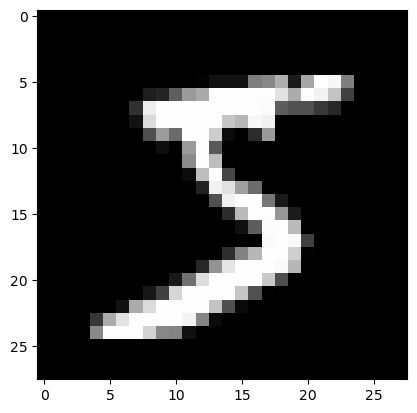

In [7]:
i, x = next(enumerate(train_loader))
x2 = np.squeeze(x[0][0])
plt.imshow(x2, cmap='gray')

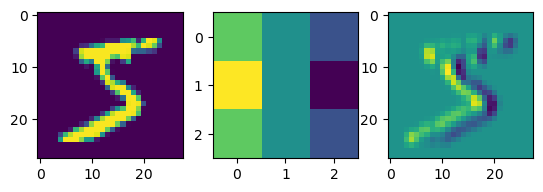

In [8]:
kernel = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
y = scipy.ndimage.convolve(x2, kernel)

fig, axes = plt.subplots(1,3)
axes[0].imshow(x2)
axes[1].imshow(kernel)
axes[2].imshow(y)

# Create Network

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [11]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
summary(network, input_size=(1,28,28))

/opt/anaconda3/envs/pytorch/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(
/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20523/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Conv2d: 1-1                            [10, 24, 24]              260
├─Conv2d: 1-2                            [20, 8, 8]                5,020
├─Dropout2d: 1-3                         [20, 8, 8]                --
├─Linear: 1-4                            [1, 50]                   16,050
├─Linear: 1-5                            [1, 10]                   510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.88
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.09
Estimated Total Size (MB): 0.15

# Visualize Weights

In [12]:
def visualize():
    i, x = next(enumerate(test_loader))
    x2 = np.squeeze(x[0][0])
    weights = network.conv1.weight.data
    
    fig, axes = plt.subplots(10,2)
    for i in range(10):
        weights_np = np.squeeze(weights.numpy()[i,0,:,:])
        axes[i,0].imshow(weights_np)
        axes[i,1].imshow(scipy.ndimage.convolve(x2, weights_np))

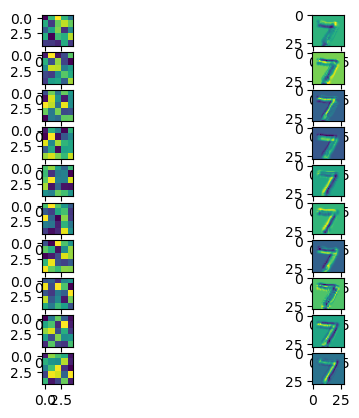

In [13]:
visualize()

# Predict Using Network

In [14]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [15]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20523/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([1, 6, 1, 1, 1])

# First Test and Train

In [16]:
def test():
  network.eval()
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  print('Test accuracy: {:.0f}%\n'.format(100. * correct / len(test_loader.dataset)))

In [17]:
test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20523/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 10%



In [18]:
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
def train():
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train loss: {:.6f}'.format(loss.item()))

In [19]:
train()

Train loss: 2.312677


/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20523/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.186441
Train loss: 1.263218
Train loss: 1.136575
Train loss: 0.781444
Train loss: 0.706059
Train loss: 0.652200
Train loss: 0.534877
Train loss: 0.582233
Train loss: 0.467827


# Train Network

In [20]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20523/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.325256
Train loss: 1.900870
Train loss: 1.177683
Train loss: 0.818873
Train loss: 0.669811
Train loss: 0.655139
Train loss: 0.472050
Train loss: 0.595135
Train loss: 0.406302
Train loss: 0.609191
Test accuracy: 95%

Train loss: 0.339889
Train loss: 0.252903
Train loss: 0.307956
Train loss: 0.410457
Train loss: 0.275216
Train loss: 0.315794
Train loss: 0.246896
Train loss: 0.327021
Train loss: 0.221444
Train loss: 0.482597
Test accuracy: 96%

Train loss: 0.283517
Train loss: 0.245341
Train loss: 0.206958
Train loss: 0.266215
Train loss: 0.195070
Train loss: 0.278523
Train loss: 0.189428
Train loss: 0.622917
Train loss: 0.323776
Train loss: 0.412633
Test accuracy: 97%

Train loss: 0.187804
Train loss: 0.135922
Train loss: 0.180786
Train loss: 0.503456
Train loss: 0.248464
Train loss: 0.165415
Train loss: 0.155432
Train loss: 0.326972
Train loss: 0.247516
Train loss: 0.376519
Test accuracy: 98%

Train loss: 0.177318
Train loss: 0.163903
Train loss: 0.109138
Train loss: 0.297

# Inspect Network

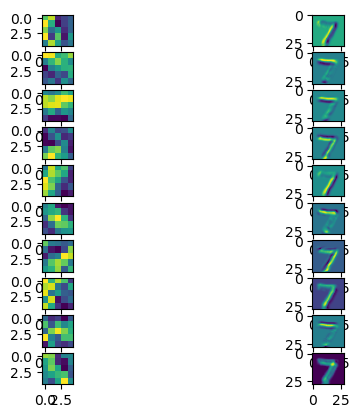

In [21]:
visualize()

In [22]:
i, x = next(enumerate(train_loader))
x[1][:5]

tensor([5, 0, 4, 1, 9])

In [23]:
y = network(x[0])
pred = y.data.max(1)[1]
pred[:5]

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20523/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


tensor([5, 0, 4, 1, 9])

# How Much Data?

#### 1a. What is the accuracy using 60,000 images? 30,000? 6,000? 3,000? 600?


1. Using 60,000 images:

In [29]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(60000)) # change it to 60,000
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20523/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.336715
Train loss: 2.032765
Train loss: 1.165865
Train loss: 0.977599
Train loss: 0.575533
Train loss: 0.554536
Train loss: 0.500612
Train loss: 0.533748
Train loss: 0.549842
Train loss: 0.392635
Test accuracy: 94%

Train loss: 0.354675
Train loss: 0.361722
Train loss: 0.285247
Train loss: 0.553561
Train loss: 0.293947
Train loss: 0.366993
Train loss: 0.305191
Train loss: 0.532918
Train loss: 0.386836
Train loss: 0.298430
Test accuracy: 96%

Train loss: 0.157104
Train loss: 0.167528
Train loss: 0.274148
Train loss: 0.489841
Train loss: 0.189830
Train loss: 0.285616
Train loss: 0.219137
Train loss: 0.226421
Train loss: 0.251944
Train loss: 0.301939
Test accuracy: 97%

Train loss: 0.239960
Train loss: 0.231451
Train loss: 0.081157
Train loss: 0.318918
Train loss: 0.147810
Train loss: 0.253212
Train loss: 0.194886
Train loss: 0.374993
Train loss: 0.218067
Train loss: 0.291583
Test accuracy: 97%

Train loss: 0.196565
Train loss: 0.201800
Train loss: 0.160357
Train loss: 0.283

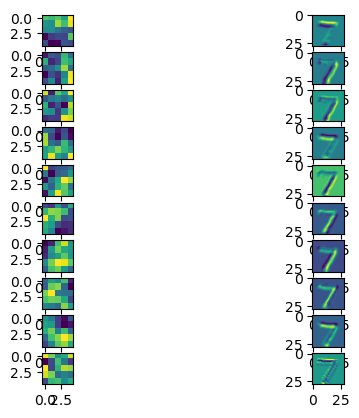

In [28]:
visualize()

2. Using 30,000 images:

In [24]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(30000))
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

In [25]:
# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20523/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.297537
Train loss: 1.856729
Train loss: 1.011191
Train loss: 0.872945
Train loss: 0.660882
Test accuracy: 92%

Train loss: 0.706182
Train loss: 0.548502
Train loss: 0.328065
Train loss: 0.440321
Train loss: 0.342549
Test accuracy: 95%

Train loss: 0.372397
Train loss: 0.463288
Train loss: 0.326144
Train loss: 0.521519
Train loss: 0.241103
Test accuracy: 96%

Train loss: 0.318509
Train loss: 0.332908
Train loss: 0.350436
Train loss: 0.497185
Train loss: 0.297045
Test accuracy: 96%

Train loss: 0.416585
Train loss: 0.367661
Train loss: 0.228327
Train loss: 0.476635
Train loss: 0.092264
Test accuracy: 97%



3. Using 6,000 images:

In [30]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(6000)) # change it to 6,000
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20523/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.304265
Test accuracy: 37%

Train loss: 2.153991
Test accuracy: 78%

Train loss: 1.216444
Test accuracy: 85%

Train loss: 0.974661
Test accuracy: 89%

Train loss: 0.633288
Test accuracy: 91%



4. Using 3,000 images:

In [31]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(3000)) # change it to 3,000
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

Train loss: 2.288024


/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20523/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Test accuracy: 50%

Train loss: 2.171186
Test accuracy: 65%

Train loss: 1.871110
Test accuracy: 74%

Train loss: 1.424903
Test accuracy: 83%

Train loss: 1.248575
Test accuracy: 84%



5. Using 600 images:

In [32]:
dataset1 = datasets.MNIST('data', train=True, download=True, transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, range(600)) # change it to 600
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=64)

# Create a new network and optimizer each time you try a new training set
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)
for epoch in range(5):
    train()
    test()

/var/folders/m9/f9b1skd55v35_qp4hcflk2qh0000gp/T/ipykernel_20523/161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train loss: 2.294358
Test accuracy: 12%

Train loss: 2.319026
Test accuracy: 15%

Train loss: 2.264916
Test accuracy: 23%

Train loss: 2.232801
Test accuracy: 29%

Train loss: 2.252108
Test accuracy: 40%



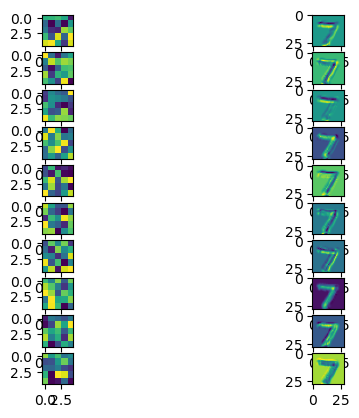

In [33]:
visualize()

- 60,000 images: the accuracy improved from 94% to 98%.
- 30,000 images: the accuracy improved from 92% to 97%.
- 6,000 images: the accuracy improved from 37% to 91%.
- 3,000 images: the accuracy improved from 50% to 84%.
- 600 images: the accuracy improved from 12% to 40%.

#### 1b. How do the weights looks different when trained with 60,000 vs 600?

The weights trained with 600 images appear significantly more random and less organized compared to those trained with 60,000 images. In the model trained with 60,000 images, the weights display more consistent patterns in terms of color and shape, suggesting that the model has achieved a higher level of accuracy and has better learned the underlying features of the data.